**Проект для воркшопа Yandex.Praktikum от SAMOKAT.TECH по настройке рекомендательной системы подбора схожих товаров.**

Практическая часть воркшопа была размещена на платформе Kaggle в формате соревнования.
https://www.kaggle.com/competitions/samokattechworkshop/overview

**Задача:** необходимо было обучить систему рекомендации (faiss либо что-то еще ) для определения 10ти наиболее схожих товаров для каждого из товара-запроса. 

**Метрика:** Recall@10. Для каждого товара находим 10 наиболее близких кандидатов. Тогда:
Recall@10 = (общая сумма найденных в топ10 матчей) / (общая сумма матчей)

Решение в этом воркбуке набрало метрику 0.73702(Public), 0.73373 (Private), что соответствует 9му месту. 

## Import libraries

In [1]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 48.7 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import faiss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from catboost import CatBoostRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/samokattechworkshop/base.csv
/kaggle/input/samokattechworkshop/train.csv
/kaggle/input/samokattechworkshop/test.csv
/kaggle/input/samokattechworkshop/baseline.ipynb
/kaggle/input/samokattechworkshop/answer_sample.csv


## Data import

Нам доступны данные:

- `base.csv` - каталог товаров в маркете
- `train.csv` - обучающая выборка с наборами товаров (запросов), по которым нужно предложить наиболее схожие рекоммендации из каталога. В качестве цели указан Id наиболее близкого товара из каталога.
- `test.csv` - выборка запросов, по которым необходимо получить рекоммендации.
- `answer_sample.csv` - образец конечного результата

In [3]:
%%time

# import raw data
base_data = pd.read_csv('/kaggle/input/samokattechworkshop/base.csv', index_col='Id')
train_data = pd.read_csv('/kaggle/input/samokattechworkshop/train.csv', index_col='Id')
test_data = pd.read_csv('/kaggle/input/samokattechworkshop/test.csv', index_col='Id')
answer_sample = pd.read_csv('/kaggle/input/samokattechworkshop/answer_sample.csv', index_col='Id')


# split train data to features and target value
train_target = train_data['Target']
train_data = train_data.drop(columns=['Target'])

CPU times: user 49 s, sys: 9.71 s, total: 58.7 s
Wall time: 1min 20s


In [4]:
print('base_data', base_data.shape, 
      'train_data', train_data.shape, 
      'train_target', train_target.shape,
      'test_data', test_data.shape)

base_data (2918139, 72) train_data (100000, 72) train_target (100000,) test_data (100000, 72)


In [5]:
base_data.iloc[:5,:10]

,0,1,2,3,4,5,6,7,8,9
Id,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064


## Data scaling

Значения признаков имеют разный масштаб значений, так что применим нормализацию признаков для корректной работы поиска ближайших соседей faiss. Обучим StandardScaler на base_data.

In [6]:
# scale data with standard scaler

scaler = StandardScaler()

base_data_changed = pd.DataFrame(scaler.fit_transform(base_data), 
                                 index=base_data.index, 
                                 columns=base_data.columns)

train_data_changed = pd.DataFrame(scaler.transform(train_data), 
                                 index=train_data.index, 
                                 columns=train_data.columns)

test_data_changed  = pd.DataFrame(scaler.transform(test_data), 
                                 index=test_data.index, 
                                 columns=test_data.columns)

## Features filtering

Поскольку у нас есть тренировочная выборка с ТОП-1 рекомендацией, можно для каждого объекта посчитать расстояние до ТОП-1 отдельно по каждой координате (delta). Признаки с высокой дисперсией этой дельты, вероятно, плохо характеризуют товар, либо слишком специфичны/ситуативны. Такие признаки с большими отклонениями отбросим.

In [7]:
# calculate coordinates delta between request and best recommendation
df1 = train_data_changed.copy().reset_index().drop(columns='Id')
df2 = base_data_changed.loc[train_target].reset_index().drop(columns='Id')

df_delta = df1 - df2

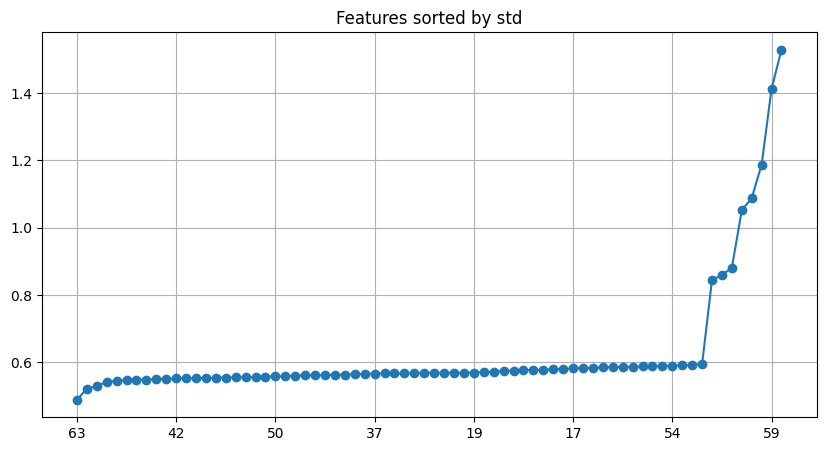

In [8]:
# get features sorted by standard deviation increase
features_sorted_std = df_delta.describe().T.sort_values(by='std')['std']
features_sorted_std.plot(kind='line', title='Features sorted by std', figsize=(10,5), style='o-', grid=True);

По графику видно, что последние восемь признаков с дисперсией значений гораздо выше, чем основная масса. Вероятно, они скорее вредят, чем способствуют точности прогноза. Удалим их из выборок.

In [9]:
# get number of remaining features
features_qty = base_data_changed.shape[1] - 8

print('Features remain:', features_sorted_std[:features_qty].index.to_list())
drop_columns = features_sorted_std[features_qty:].index.to_list()
print('\nFeatures to drop:', drop_columns)

Features remain: ['63', '35', '10', '15', '71', '68', '34', '56', '61', '30', '42', '1', '36', '57', '28', '22', '67', '49', '14', '31', '50', '66', '58', '9', '29', '3', '48', '20', '46', '45', '37', '52', '16', '13', '12', '55', '38', '43', '5', '41', '19', '53', '8', '40', '69', '0', '64', '11', '32', '4', '17', '23', '24', '2', '47', '39', '7', '27', '62', '60', '54', '51', '26', '18']

Features to drop: ['70', '44', '6', '25', '21', '65', '59', '33']


In [10]:
# drop Features here
base_data_changed.drop(columns = drop_columns, inplace=True)
train_data_changed.drop(columns = drop_columns, inplace=True)
test_data_changed.drop(columns = drop_columns, inplace=True)

print('base_data_changed', base_data_changed.shape, 
      'train_data_changed', train_data_changed.shape, 
      'test_data_changed', test_data_changed.shape)

base_data_changed (2918139, 64) train_data_changed (100000, 64) test_data_changed (100000, 64)


## Train faiss

Натренируем faiss с перебором гиперпараметров. Для этого заведем вспомогательные функции:
- `train_faiss` - обучение модели FAISS с предоставленными параметрами количества кластеров, метрикой расчета расстояний до ближайшего соседа. Функция возвратит натренированный классификатор.

In [11]:
# helper function to train faiss with specific parameters
def train_faiss(data, clusters = 100, metric=faiss.METRIC_INNER_PRODUCT):
    features = data.shape[1] # amount of features
    setup = f'IVF{clusters},Flat'
    index = faiss.index_factory(features, setup, metric)
    index.train(data) 
    index.add(data)
    return index

- `evaluate_faiss` - функция оценки качества предсказаний модели. На входе получает обученную FAISS модель, тренировочные данные. Далее считает ТОП-N рекомендаций и процент попадания в них рекомендации ТОП-1 из тренировочного Target.

In [12]:
# helper function to evaluate results
def evaluate_faiss(index, train_data, train_target, base_data, topn=1, nprobe = 1):
    
    # amount of faiss clusters to search in
    index.nprobe = nprobe  
    
    # search TOPN closest entities
    _ , I = index.search(train_data, topn)
    
    # measure result
    y = pd.DataFrame(train_target)
    y['preds'] = None
    y['match'] = 0
    for i,val in enumerate(I):
        y.iloc[i,1] = ' '.join(base_data.index[x] for x in val)
        y.iloc[i,2] = y.iloc[i,0] in y.iloc[i,1] # check match here
     
    return y['match'].mean()

Запускаем цикл обучения с подбором гиперпараметров FAISS. Мы можем управлять метрикой измерения расстояния (`metric`), количеством кластеров (`clusters`), на которое разделим всю совокупность данных и количество кластеров отсматривать при расчете рекомендаций (`nprobe`).

Для каждой комбинации параметров мы обучим FAISS и проведем оценку финальной метрики. Классификатор с наилучшей метрикой попадают в переменную `best_index`

In [13]:
topn = 10
index = None

best_clusters = 0
best_metric = 0
best_nprobe = 0
best_result = 0 
best_index = None

np.random

for clusters in [int(base_data_changed.shape[0]**0.5)]: #[500, 1000, 1500, 2000, 2500, 3000, int(base_data_changed.shape[0]**0.5)]
    for metric in [faiss.METRIC_L2]:  # [faiss.METRIC_INNER_PRODUCT, faiss.METRIC_L2]
        for nprobe in [250]: # [16, 32, 64, 100, 250]
            index = train_faiss(base_data_changed, clusters, metric) # train model
            index.nprobe = nprobe  
            result = evaluate_faiss(index, train_data_changed, train_target, base_data_changed, topn, nprobe) # evaluate
        
            print(f'Train clusters={clusters}, metric={metric}, nprobe={nprobe}, result={result}')
            
            if best_result<result:
                best_clusters = clusters
                best_metric = metric
                best_nprobe = nprobe
                best_result = result 
                best_index = index
            
print(f'\nBEST clusters={best_clusters}, metric={best_metric}, nprobe={best_nprobe}, result={best_result}')

Train clusters=1708, metric=1, nprobe=250, result=0.73671

BEST clusters=1708, metric=1, nprobe=250, result=0.73671


## Make submission

У нас есть обученная модель с оптимальными гиперпараметрами. Теперь сделаем предсказания топ-10 товаров для каждого товара из запроса.

In [14]:
# find topn recommendations for each target item
topn = 10
D , I = best_index.search(test_data_changed, topn)

In [15]:
I

array([[1954150, 2192372, 1225777, ...,  340288, 1719453,  814942],
       [1902634,  157966,   11829, ..., 1162720, 1459534, 1884931],
       [ 431806,  451870,   24989, ...,  359945,  318265, 1825274],
       ...,
       [1392746, 1731267,  991639, ...,  209755,   99184,  349609],
       [ 319526, 2820290,   77792, ..., 1087791,  442664, 2622710],
       [1811737, 1537302, 1985371, ...,  233242,  451450,  234056]])

Получили массив с порядковыми номерами (не индексами) товаров из `base_data`. Сформируем итоговый файл с предсказаниями `submission.csv`, в который по этим порядковым номерам подтянем Id товаров-рекоммендаций.

In [16]:
submission = pd.DataFrame(columns=['Id', 'Predicted'])

submission['Id'] = test_data_changed.index
submission['Predicted'] = list(I)
submission = submission.explode('Predicted')
submission['Predicted'] = base_data_changed.index[list(submission['Predicted'])]
submission = submission.groupby('Id')['Predicted'].apply(' '.join).reset_index()

submission

,Id,Predicted
0,100000-query,2760762-base 3209652-base 1542803-base 3839597...
1,100001-query,2666508-base 163485-base 11853-base 1000521-ba...
2,100002-query,472256-base 496010-base 25113-base 153272-base...
3,100003-query,3168654-base 1831175-base 2345993-base 4473809...
4,100004-query,1217188-base 75484-base 2366033-base 2863148-b...
...,...,...
99995,199995-query,880713-base 250053-base 3385639-base 962150-ba...
99996,199996-query,272706-base 2653840-base 220273-base 936053-ba...
99997,199997-query,1801591-base 2362444-base 1200061-base 654974-...
99998,199998-query,341779-base 4523822-base 79148-base 3024721-ba...


 Сохраним файл на диск.

In [17]:
submission.to_csv('submission.csv', index=False)

## Other tested ideas (not affecting result)

<div class="alert alert-block alert-danger"> 
Весь код ниже - вырезки из разных экспериментов с моделью. Он приведен в справочных целях и не влияет на результат формирования файла submission.csv </div>

**Catboost stupid ranking model**

Ниже я пробовал прикрутить модель второго уровня, которая могла бы оценить пригодность рекомендованного товара. Это модель регрессии, результат которой - чем выше, тем ближе рекомендация к запросу. Предполагалось обучать модель на синтезированных данных, где самый ближайший сосед из обучающей выборки имеет значение таргета =1 , а нерелевантная рекомендация - значение =0.

**По итогу - не удалось обучить модель отличать близкие рекомендации от неблизких.** 

Вероятно, ошибка в подготовке обучающей выборки, хотя пробовал несколько вариантов формирования нерелевантных рекомендаций, в т.ч. выбором случайного товара из общей базы товаров. 

---


Подготовим обучающий датасет, на котором будут отделяться релевантные объекты от нерелевантных. 
Список релевантных у нас есть - это данные таблицы train. Нерелевантные объекты сгенерируем самостоятельно - для каждого query подтянем случайный объект из данных.

In [ ]:

# GENERATE NOT RELEVANT SAMPLES (MARKED AS 0)

topn = 1
best_index.nprobe = 10  
max_items=100

# find closest neighbours 
D , I = best_index.search(train_data_changed[:max_items], topn)

# generate dataframe with pairs REQUEST-RECOMMENDATION 
df = pd.DataFrame(columns=['Id_q', 'Id_r'])
df['Id_q'] = train_data_changed.index[:max_items]
df['Id_r'] =  list(I)
df = df.explode('Id_r')
df['Id_r'] = base_data_changed.index[list(df['Id_r'])]

# drop known best recomendations
recs_drop=list(train_target)
df = df.query('Id_r not in @recs_drop')
df.columns=['Id','Target']

 
# generate non relevant samples
df_nonrelevant =df
df_nonrelevant['relevance'] = 0

Создадим простую модель регрессии, которую научим отличать релевантные пары от нерелевантных

In [ ]:
# GENERATE RELEVANT DATA (MARKED as 1)
df_relevant = df.drop(columns='Target').merge(train_target.reset_index(), on ='Id')
df_relevant['relevance'] = 1

In [ ]:
# COMBINE IN TRAIN DATASET

df = pd.concat([df_nonrelevant, df_relevant])

X = df.drop(columns=['relevance'])
y = df.drop(columns=['Id', 'Target'])

X = X.merge(train_data_changed.reset_index(), on='Id')
X.drop(columns='Id', inplace=True)
X = X.merge(base_data_changed.reset_index(), left_on='Target', 
                        right_on = 'Id', suffixes=['_query','_base'])
X.drop(columns=['Id','Target'], inplace=True)
 

print('X.shape:', X.shape, 'y.shape:', y.shape)

In [ ]:
# TRAIN MODEL

model = CatBoostRegressor(random_state=1, iterations=300)

x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.001, random_state=42, shuffle=True)
model.fit(x_train, y_train, verbose=100)

# test ranking
print('Rank value on non relevant items', model.predict(X.loc[:1000]).mean())
print('Rank value on relevant items', model.predict(X.loc[-1000:]).mean())

    Learning rate set to 0.070749
    0:	learn: 0.4887968	total: 61.1ms	remaining: 18.3s
    100:	learn: 0.0321425	total: 391ms	remaining: 769ms
    200:	learn: 0.0061126	total: 716ms	remaining: 353ms
    299:	learn: 0.0011144	total: 1.05s	remaining: 0us
    Rank value on non relevant items 0.49829480289605027
    Rank value on relevant items 0.49829480289605027

Видно, что результат регрессии для релевантных и нерелевантных рекоммендаций не отличается. Значит модель не может их отделить

**Catboost submission ranking**


Делаем предсказание в 2 этапа. 
1. Находим topn ближайших соседей моделью FAISS. Ищем соседей с запасом, чтобы было из чего выбрать на втором шаге
2. ранжируем найденных соседей моделью CATBOOST и оставляем топ 10

In [ ]:
# 1 - find topn recommendations for each target item with FAISS
topn = 50
D , I = best_index.search(test_data_changed, topn)

# 2 - Catboost sorting

df = pd.DataFrame(columns=['Id_q', 'Id_r'])
df['Id_q'] = test_data_changed.index
df['Id_r'] = list(I)
df = df.explode('Id_r')
df['Id_r'] = base_data_changed.index[list(df['Id_r'])]


df = df.merge(test_data_changed.reset_index(), left_on='Id_q', right_on='Id')
df = df.merge(base_data_changed.reset_index(), left_on='Id_r', 
                        right_on = 'Id', suffixes=['_query','_base'])

# generate predictions for every pair Query-Recommendation
preds = model.predict(df.drop(columns=['Id_q','Id_r','Id_query', 'Id_base']))
preds

df['preds'] = preds
df = df[['Id_q', 'Id_r', 'preds']]

#  get top recomendations for every request
topn = 10
submission = df.sort_values('preds', ascending=False).groupby('Id_q').head(topn)
submission['Id_q'].value_counts()

    110225-query    10
    199281-query    10
    107596-query    10
    105244-query    10
    154774-query    10
                    ..
    194848-query    10
    197305-query    10
    164764-query    10
    171160-query    10
    159548-query    10
    Name: Id_q, Length: 100000, dtype: int64